# The purpose of this notebook

This is the final notebook that makes figures for the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
n_boot = 100000

In [4]:
from IPython.display import display, HTML

import string

import numpy as np
np.set_printoptions(precision=3)

import pandas as pd
pd.set_option('display.max_rows', 500)

import scipy.stats as st
import statsmodels.stats.multitest as mt

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

import suppression as s
import utils

In [5]:
pd.__version__

'1.2.3'

In [6]:
sns.__version__

'0.11.1'

In [7]:
gaba_fn = 'gaba_data_2019.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [8]:
sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all' #'motor' # or 'occ_binoc', 'mean_occ_all', 'motor'
gdf = utils.load_gaba(gaba_fn, gaba_col)
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2


In [9]:
def categorize(df, col, values=None):
    df[col] = df[col].astype("category")
    if values is not None:
        if len(values)==len(df[col].cat.categories):
            df[col].cat.rename_categories(values, inplace=True)
            df[col].cat.reorder_categories(values.values(), inplace=True)
    return df

pop_dict = {'Amblyope':'PWA', 'Control':'NSP'}

gdf = categorize(gdf, 'Population', pop_dict)
sdf = categorize(sdf, 'Population', pop_dict)

In [10]:
gdf.Population.cat.categories

Index(['PWA', 'NSP'], dtype='object')

In [11]:
demos = pd.read_csv('demos.csv', lineterminator="\r")
# 1 = amb, 0 = control
subs_to_swap_eyes = demos[demos.swapNDE_EY==1].initials.unique() # subjects whose NDE/DE assignment is wrong in sdf
print(subs_to_swap_eyes)
demos

['ai' 'ct' 'dl' 'ei' 'kw' 'nl']


,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,0,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,1,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,0,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203


In [12]:
demos[demos.initials=='nl']

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
22,34,nl,NL_060814,33,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.21,0.218


### Set variables used for graphing

In [13]:
colors2 = {'PWA':'#1f77b4', 'NSP':'#ff7f0e'}
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\npersons, DE", f"Normally-sighted\npersons, NDE"]
pal4 = {}
pal4g = {}
for t, c in zip(traces4, colors4):
    pal4[t] = c
for t, c in zip(traces_graph4, colors4):
    pal4g[t] = c
print(pal4, pal4g, sep='\n')
plot_dir = f"plots/cercor2021"

{'Amblyope-De': '#3274a1', 'Amblyope-Nde': '#72b4e1', 'Control-De': '#e1812c', 'Control-Nde': '#ffc68c'}
{'Persons with\nAmblyopia, DE': '#3274a1', 'Persons with\nAmblyopia, NDE': '#72b4e1', 'Normally-sighted\npersons, DE': '#e1812c', 'Normally-sighted\npersons, NDE': '#ffc68c'}


In [14]:
!ls "plots"

cercor2021                         redo-201902-exclude_bad_fits
collab-201710                      redo-201904-mean_occ_all
mas-20170921-os                    redo-201904-mean_occ_stim
mas-20170921-ss                    redo-201904-motor
redo-201805                        redo-201904-occ_binoc
redo-201807                        redo-201908-mean_occ_all-weighted
redo-201809                        redo-201910-mean_occ_all-bootstrap
redo-201810                        redo-202001-mean_occ_all-fixeyes
redo-201901                        revise2021


## Demographic stuff from KB

In [15]:
amb_data = demos[demos['group']==1].copy()
amb_data['motorGABA'] = pd.to_numeric(amb_data['motorGABA'].str.strip(), errors='coerce')
amb_data[["numID","initials","age","labelGroup","labelNDE","swapNDE_EY","acuityDE","acuityNDE",
          "iadLogMAR","occGABA","motorGABA"]]
# amb subs with both gaba and psychophys = ['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd']

,numID,initials,age,labelGroup,labelNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,36,PWA,right,0,-0.204120,0.116910,0.321030,0.198,0.215
2,6,as,39,PWA,left,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,52,PWA,right,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,33,PWA,left,0,-0.084939,1.176091,1.261030,0.184,NaN
6,12,cs,46,PWA,right,0,-0.096910,0.281030,0.377940,0.220,NaN
10,17,em,61,PWA,left,0,-0.096910,0.497121,0.594031,0.185,0.215
11,19,gd,50,PWA,left,0,-0.164000,0.398000,0.562000,0.197,0.208
14,24,jv,19,PWA,right,0,-0.085000,0.538000,0.623000,0.201,0.205
15,26,ks,44,PWA,left,0,-0.204000,0.261000,0.465000,0.207,0.211
17,28,li,25,PWA,left,0,0.000000,0.224000,0.224000,0.216,NaN


In [16]:
#tt_eyes = st.ttest_ind(amb_data['acuityDE'], amb_data['acuityNDE'], nan_policy='omit') # are the eyes different in acuity?
#print(tt_eyes)
#print("occ gaba vs acuityDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityDE'], nan_policy='omit'))
#print("occ gaba vs acuityNDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityNDE'], nan_policy='omit'))
print("occ gaba vs IAD: ", st.spearmanr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs IAD: ", st.spearmanr(amb_data['motorGABA'], amb_data['iadLogMAR'], nan_policy='omit'))

occ gaba vs IAD:  SpearmanrResult(correlation=-0.6365654208460114, pvalue=0.014373530547495347)
motor gaba vs IAD:  SpearmanrResult(correlation=0.21276694028802262, pvalue=0.5550759959985581)


In [17]:
print("occ gaba vs interocular acuity difference: ", st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs interocular acuity difference: ", np.corrcoef(amb_data['motorGABA'], amb_data['iadLogMAR'])[0,1])
#print("motor gaba vs interocular acuity difference: ", st.pearsonr(amb_data['motorGABA'], amb_data['iadLogMAR']))

occ gaba vs interocular acuity difference:  (-0.7056578245904567, 0.004805440709063252)
motor gaba vs interocular acuity difference:  nan


In [18]:
print(amb_data['occGABA'], amb_data["motorGABA"], sep='\n')

0     0.198
2     0.217
3     0.205
4     0.184
6     0.220
10    0.185
11    0.197
14    0.201
15    0.207
17    0.216
19    0.217
23    0.207
24    0.200
25    0.187
Name: occGABA, dtype: float64
0     0.215
2     0.196
3     0.219
4       NaN
6       NaN
10    0.215
11    0.208
14    0.205
15    0.211
17      NaN
19    0.227
23    0.204
24    0.210
25      NaN
Name: motorGABA, dtype: float64


In [19]:
has_motor = amb_data[~np.isnan(amb_data['motorGABA'])]

In [20]:
len(amb_data['occGABA']), len(has_motor['motorGABA'])

(14, 10)

#### Demographic info for controls

In [21]:
nsp_demos = demos[demos['group']==0].copy()
nsp_demos

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203
12,22,jd,JD_090414,51,2,male,0,NSP,2,0,...,1,1,left,baselineSS,0,NaN,NaN,NaN,0.194,0.185
13,23,jm,JM_092914,42,1,female,0,NSP,1,0,...,0,2,right,sightingTest,0,NaN,NaN,NaN,0.211,0.212
16,27,kw,KW_051814,27,1,female,0,NSP,1,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.203,0.194
18,29,ls,LS_032214,55,1,female,0,NSP,1,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.193,0.202
20,31,mk,MK_032214,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,0,NaN,NaN,NaN,0.197,0.189


In [22]:
np.unique(nsp_demos.initials)

array(['ai', 'cr', 'ct', 'dl', 'ei', 'jd', 'jm', 'kw', 'ls', 'mk', 'ms',
       'nl', 'yl'], dtype=object)

In [23]:
np.count_nonzero(nsp_demos.labelSex=='female')

6

In [24]:
demos

,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,0,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,1,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,0,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203


### Figure 5

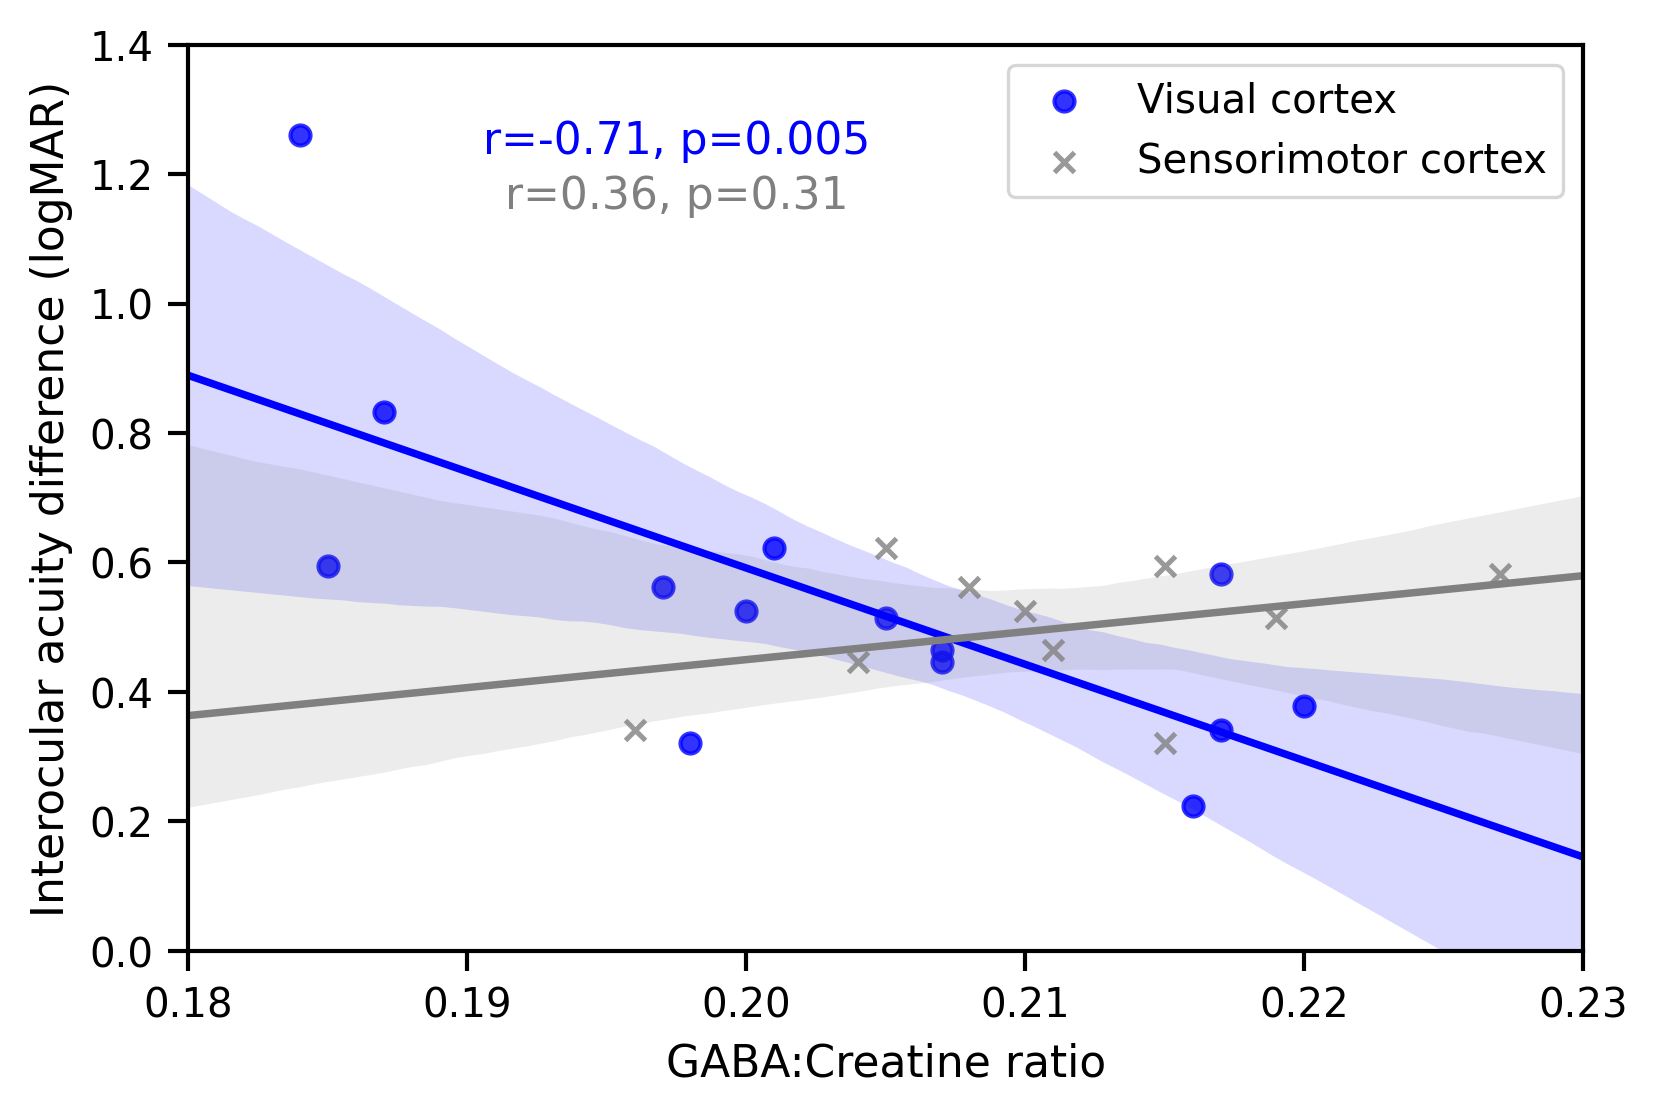

In [25]:
#with s.PdfPages(f"{plot_dir}/figure_05.pdf") as pdf:
sns.set_context(context="paper", font_scale=1.1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=300)
ax.set_xlim(0.18, 0.23)
ax.set_ylim(0, 1.4)

sns.regplot(data=amb_data, x='occGABA', y='iadLogMAR', color='blue', marker='o', ax=ax, label='Visual cortex', truncate=False)
r, p = st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR'])
ax.text(.35, 0.88, f"r={r:.2f}, p={p:.3f}", transform=ax.transAxes, fontdict={'color': 'blue'}, horizontalalignment='center')

sns.regplot(data=amb_data, x='motorGABA', y='iadLogMAR', color='grey', marker='x', ax=ax, label='Sensorimotor cortex', truncate=False)
r, p = st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])
ax.text(.35, 0.82, f"r={r:.2f}, p={p:.2f}", transform=ax.transAxes, fontdict={'color': 'grey'}, horizontalalignment='center')

ax.legend()
ax.set_xlabel("GABA:Creatine ratio")
ax.set_ylabel("Interocular acuity difference (logMAR)")
fig.savefig(f"{plot_dir}/figure_05.pdf", dpi='figure')
plt.show()
plt.close('all')

In [26]:
np.corrcoef(has_motor['motorGABA'], has_motor['iadLogMAR'])

array([[1.  , 0.36],
       [0.36, 1.  ]])

In [27]:
st.pearsonr(has_motor['motorGABA'], has_motor['iadLogMAR'])

(0.3602346498548901, 0.30653032721555246)

## Analyze tasks separately (before subsetting to include common subjects)

In [28]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [29]:
gdf

,subjName,Population,Presentation,GABA
2,ac,PWA,mean_occ_all,0.198
6,am,PWA,mean_occ_all,0.194
10,as,PWA,mean_occ_all,0.217
14,bi,PWA,mean_occ_all,0.205
18,ch,PWA,mean_occ_all,0.184
22,cs,PWA,mean_occ_all,0.220
26,em,PWA,mean_occ_all,0.185
30,gd,PWA,mean_occ_all,0.197
34,jv,PWA,mean_occ_all,0.201
38,ks,PWA,mean_occ_all,0.207


#### Remove AM and TT based on discussions with Kelly 12/2019.

In [30]:
gdf_reduced = gdf[(gdf.subjName != 'am') & (gdf.subjName !='tt')]
pop_group_reduced = gdf_reduced.groupby("Population")
pop_group_reduced.describe()

GABA                                                           
           count      mean       std    min      25%    50%      75%    max
Population                                                                 
PWA         14.0  0.202929  0.012092  0.184  0.19725  0.203  0.21375  0.220
NSP         15.0  0.205800  0.009443  0.193  0.19850  0.203  0.21100  0.223

In [31]:
#print(*pop_group_reduced['GABA'])
gaba_per_group = [col for col_name, col in pop_group_reduced['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-0.7154537449760946 0.48047050303580574


In [32]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
           count      mean       std    min     50%    max
Population                                                
PWA         16.0  0.199813  0.015276  0.162  0.2005  0.220
NSP         15.0  0.205800  0.009443  0.193  0.2030  0.223

In [33]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-1.3018940582990504 0.20319932494233103


**Thus we find no significant difference in GABA levels between CON and AMB regardless of whether AM and TT are included. At this point we may as well proceed with gdf_reduced only.**

### GABA violin plot, all subjects

In [34]:
gdf = gdf_reduced.copy()
gaba_df_immutable = gdf_reduced.copy()
gaba_df_immutable.groupby("Population").describe() # Shoud be 14 PWA due to AM, TT exclusion

GABA                                                           
           count      mean       std    min      25%    50%      75%    max
Population                                                                 
PWA         14.0  0.202929  0.012092  0.184  0.19725  0.203  0.21375  0.220
NSP         15.0  0.205800  0.009443  0.193  0.19850  0.203  0.21100  0.223

In [35]:
(np.sum((gaba_df_immutable['GABA']-.203)**2)**.5)/6

0.00952627944162882

In [36]:
gaba_df_immutable.to_csv('gaba_data.csv')

In [37]:
0.009443/(15**.5)

0.0024381721158824423

#### Figure 4

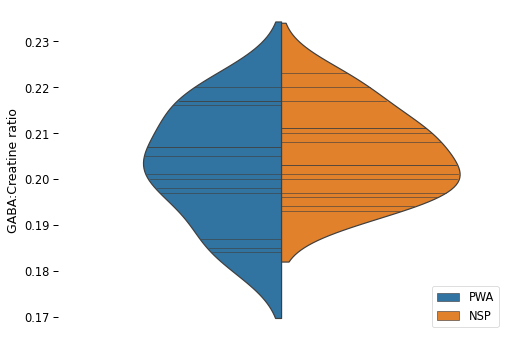

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [38]:
#with s.PdfPages(f"{plot_dir}/figure_04.pdf") as pdf:
#with sns.plotting_context(context=None, font_scale=1.3):
sns.set_context(context="paper", font_scale=1.3)
fig = plt.figure(figsize=(8,6))  # create a figure object
ax = fig.add_subplot(1, 1, 1)
ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gaba_df_immutable,split=True,inner='stick',ax=ax,legend=False, palette=colors2)
ax.legend(loc=4)
ax.xaxis.set_visible(False)
ax.set_ylabel('GABA:Creatine ratio')
sns.despine(left=True, bottom=True, right=True)
#ax.set_yticklabels([])
plt.show(ax.figure)
ax.figure.savefig(f"{plot_dir}/figure_04.eps", format="eps")
plt.show()
plt.close(ax.figure)
plt.close('all')

### Note: the subject with the lowest GABA:Cr ('tt', .162) is not in the psychophysics data

# Select one psychophysical task's data #

In [39]:
task = 'SS' # 'SS'
sdf = sdf[sdf['Task']==task]
df_to_model = sdf.copy(deep=True) # make a deep copy

In [40]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,Nde,NSP,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2
1,ai,SS,nMono,Iso,Nde,NSP,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4
2,ai,SS,nMono,Iso,Nde,NSP,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6
3,ap,SS,nMono,Iso,Nde,NSP,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1
4,ap,SS,nMono,Iso,Nde,NSP,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2


In [41]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="PWA"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


### Verifying baselines based on KB feedback about fig R2

In [42]:
onecond = df_to_model[(df_to_model['Presentation']=='nMono') & (df_to_model['Orientation']=='Iso')]

In [43]:
cnde_subs = onecond[onecond['Trace']=='Control-Nde'].Subject.unique()

In [44]:
cde_subs = onecond[onecond['Trace']=='Control-De'].Subject.unique()

In [45]:
np.setdiff1d(cnde_subs, cde_subs)

array(['ap', 'bo', 'gw', 'ke', 'nn', 'tj'], dtype=object)

In [46]:
thresh_noswap = onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace','Subject'], as_index=False)['BaselineThresh'].mean().dropna()

In [47]:
thresh_noswap.head()

,Task,Orientation,Presentation,Population,Eye,Trace,Subject,BaselineThresh
0,SS,Iso,nMono,PWA,De,Amblyope-De,ah,7.590
2,SS,Iso,nMono,PWA,De,Amblyope-De,am,7.532
4,SS,Iso,nMono,PWA,De,Amblyope-De,bi,7.827
6,SS,Iso,nMono,PWA,De,Amblyope-De,cl,6.709
10,SS,Iso,nMono,PWA,De,Amblyope-De,eg,6.826


In [48]:
eye_counts = thresh_noswap['Subject'].value_counts().reset_index()

In [49]:
eye_counts

,index,Subject
0,ls,2
1,ct,2
2,cr,2
3,dl,2
4,cl,2
5,es,2
6,tm,2
7,ah,2
8,bi,2
9,mk,2


In [50]:
nounpaired = (eye_counts[eye_counts.Subject==2])['index'].unique()

In [51]:
nounpaired

array(['ls', 'ct', 'cr', 'dl', 'cl', 'es', 'tm', 'ah', 'bi', 'mk', 'se',
       'li', 'gm', 'mg', 'ai', 'jd', 'nl', 'am', 'kw', 'rn', 'jv', 'yl',
       'ei', 'em', 'sd', 'gd', 'mv', 'eg', 'ms'], dtype=object)

In [52]:
thresh_noswap_nounpaired = thresh_noswap[thresh_noswap['Subject'].isin(nounpaired)]

In [53]:
thresh_noswap.groupby(['Trace']).mean().reset_index()

,Trace,BaselineThresh
0,Amblyope-De,6.136462
1,Amblyope-Nde,7.318385
2,Control-De,6.309750
3,Control-Nde,5.894955


In [54]:
thresh_noswap_nounpaired.groupby(['Trace']).describe()

BaselineThresh                                              \
                      count      mean       std    min      25%     50%   
Trace                                                                     
Amblyope-De            13.0  6.136462  1.280663  4.063  5.94900  6.2620   
Amblyope-Nde           13.0  7.318385  2.364243  4.558  5.94400  6.7870   
Control-De             16.0  6.309750  1.559247  4.033  5.42650  6.0295   
Control-Nde            16.0  5.921750  1.467759  3.124  5.20325  5.6900   

                               
                  75%     max  
Trace                          
Amblyope-De   6.82600   7.827  
Amblyope-Nde  7.83400  13.226  
Control-De    6.90475   9.987  
Control-Nde   6.68325   8.794

<AxesSubplot:xlabel='Population', ylabel='BaselineThresh'>

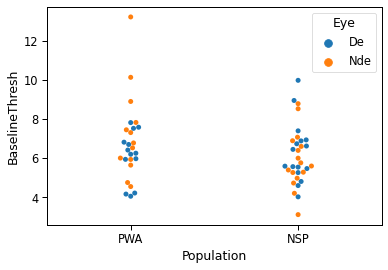

In [55]:
sns.swarmplot(data=thresh_noswap_nounpaired, x="Population", y="BaselineThresh", hue="Eye")

### This is where the NDE/DE should be switched based on KB findings (only affects Controls, luckily)

But as the above plot shows, there are many more in Control-Nde than Control-De

In [56]:
subs_to_swap_eyes_baselineSS = []
for gv, g in thresh_noswap_nounpaired.groupby(['Subject']):
    print(gv)#, g[['Eye','BaselineThresh']])
    nde_thresh = g[g.Eye=='Nde']['BaselineThresh'].iloc[0]
    de_thresh = g[g.Eye=='De']['BaselineThresh'].iloc[0]
    diff = nde_thresh - de_thresh
    is_nsp = np.all(g['Population']=='NSP')
    if is_nsp and diff < 0:
        print("This subject has a lower threshold in Nde than De but is a NSP!")
        subs_to_swap_eyes_baselineSS.append(g.Subject.iloc[0])

ah
ai
This subject has a lower threshold in Nde than De but is a NSP!
am
bi
cl
cr
This subject has a lower threshold in Nde than De but is a NSP!
ct
This subject has a lower threshold in Nde than De but is a NSP!
dl
This subject has a lower threshold in Nde than De but is a NSP!
eg
ei
This subject has a lower threshold in Nde than De but is a NSP!
em
es
gd
gm
This subject has a lower threshold in Nde than De but is a NSP!
jd
This subject has a lower threshold in Nde than De but is a NSP!
jv
kw
This subject has a lower threshold in Nde than De but is a NSP!
li
ls
This subject has a lower threshold in Nde than De but is a NSP!
mg
mk
ms
This subject has a lower threshold in Nde than De but is a NSP!
mv
nl
rn
sd
se
This subject has a lower threshold in Nde than De but is a NSP!
tm
This subject has a lower threshold in Nde than De but is a NSP!
yl
This subject has a lower threshold in Nde than De but is a NSP!


In [57]:
subs_to_swap_eyes_baselineSS

['ai', 'cr', 'ct', 'dl', 'ei', 'gm', 'jd', 'kw', 'ls', 'ms', 'se', 'tm', 'yl']

In [58]:
def swap_eyevars(df, subs):
    #print(df, df['Subject'], len(df), sep='\n')
    if df['Subject'] in subs: # fix here
        print(df['Subject'], "SWAP!")
        if df['Eye'] == "De":
            df['Eye'] = "Nde"
            df['Trace'] = df['Trace'].replace('-De', '-Nde')
        else:
            df['Eye'] = "De"
            df['Trace'] = df['Trace'].replace('-Nde', '-De')
    return df

def fix_eyes(df):
    disp_cols = ['Subject','Eye','Trace','BaselineThresh']
    # Identify which rows are of subjects that should be swapped
    # Changed 6/18/21 to include the possibility of assigning eyes based on baseline surround suppression
    subs_to_swap_eyes = subs_to_swap_eyes_baselineSS # assign NSP eyes purely based on baselineSS, disregarding swapNde_EY etc.
    rows_to_change = df_to_model[df_to_model.Subject.isin(subs_to_swap_eyes)]
    assert(np.all(rows_to_change.Population == 'NSP')) # should only affect controls
    assert(np.all(rows_to_change.Trace.isin(['Control-De','Control-Nde']))) # these should be swapped along w/ Eye
    fixed = df.apply(swap_eyevars, subs=subs_to_swap_eyes, axis=1)
    print(fixed[disp_cols])
    return fixed

df_to_model_fixeyes = fix_eyes(df_to_model)

ai SWAP!
ai SWAP!
ai SWAP!
cr SWAP!
cr SWAP!
cr SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
jd SWAP!
jd SWAP!
jd SWAP!
kw SWAP!
kw SWAP!
kw SWAP!
ls SWAP!
ls SWAP!
ls SWAP!
ms SWAP!
ms SWAP!
ms SWAP!
se SWAP!
se SWAP!
se SWAP!
tm SWAP!
tm SWAP!
tm SWAP!
yl SWAP!
yl SWAP!
yl SWAP!
ai SWAP!
ai SWAP!
ai SWAP!
cr SWAP!
cr SWAP!
cr SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
jd SWAP!
jd SWAP!
jd SWAP!
kw SWAP!
kw SWAP!
kw SWAP!
ls SWAP!
ls SWAP!
ls SWAP!
ms SWAP!
ms SWAP!
ms SWAP!
se SWAP!
se SWAP!
se SWAP!
tm SWAP!
tm SWAP!
tm SWAP!
yl SWAP!
yl SWAP!
yl SWAP!
ai SWAP!
ai SWAP!
ai SWAP!
cr SWAP!
cr SWAP!
cr SWAP!
ct SWAP!
ct SWAP!
ct SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
dl SWAP!
ei SWAP!
ei SWAP!
ei SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
gm SWAP!
jd SWAP!
jd SWAP!
jd SWAP!
k

In [59]:
df_to_model_fixeyes.groupby("Trace")['BaselineThresh'].describe()

,count,mean,std,min,25%,50%,75%,max
Trace,,,,,,,,
Amblyope-De,208.0,6.170423,1.226235,4.063,5.949,6.262,6.826,7.827
Amblyope-Nde,204.0,7.228000,2.152685,4.558,5.944,6.787,7.834,13.226
Control-De,216.0,5.826167,1.357432,3.124,4.985,5.552,6.405,8.794
Control-Nde,342.0,6.174883,1.385176,4.033,5.205,5.741,6.745,9.987


### Toggle which version of the data to use, "fixed" eyes or not

In [60]:
df_to_model = df_to_model_fixeyes

# Preparation for Modeling

In [61]:
df_to_model.head() # note the first rows, they will tell if fixed - ai/Nde/6.9 -> ai/De/6.9 

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,De,NSP,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2
1,ai,SS,nMono,Iso,De,NSP,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4
2,ai,SS,nMono,Iso,De,NSP,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6
3,ap,SS,nMono,Iso,Nde,NSP,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1
4,ap,SS,nMono,Iso,Nde,NSP,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2


### Begin grouping data into conditions to model Subject's ThreshElev as a function of MaskContrast

In [62]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

groups_with_baseline = df_to_model.groupby(pp_gvars_base)

# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

### BaselineThresh analysis before modeling

In [63]:
print(pp_gvars_base)
pp_gvars_base_agg = [v for v in pp_gvars if v != 'Subject']

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [64]:
pp_gvars_base_agg

['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace']

In [65]:
for gv, g in df_to_model.groupby(pp_gvars_base_agg):
    print(gv, len(np.unique(g['BaselineThresh'])))

('SS', 'Cross', 'nDicho', 'NSP', 'De', 'Control-De') 16
('SS', 'Cross', 'nDicho', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nDicho', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nDicho', 'PWA', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nMono', 'NSP', 'De', 'Control-De') 16
('SS', 'Cross', 'nMono', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nMono', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nMono', 'PWA', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nDicho', 'NSP', 'De', 'Control-De') 16
('SS', 'Iso', 'nDicho', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nDicho', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nDicho', 'PWA', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nMono', 'NSP', 'De', 'Control-De') 16
('SS', 'Iso', 'nMono', 'NSP', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nMono', 'PWA', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nMono', 'PWA', 'Nde', 'Amblyope-Nde') 13


In [66]:
thresh_swap = df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Subject','Eye', 'Trace'])['BaselineThresh'].mean().reset_index()
thresh_swap = thresh_swap[(thresh_swap.Orientation=="Iso")&(thresh_swap.Presentation=='nDicho')]
thresh_swap.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh
128,SS,Iso,nDicho,NSP,ai,De,Control-De,6.900
129,SS,Iso,nDicho,NSP,ai,Nde,Control-Nde,6.943
130,SS,Iso,nDicho,NSP,ap,Nde,Control-Nde,5.205
131,SS,Iso,nDicho,NSP,bo,Nde,Control-Nde,4.462
132,SS,Iso,nDicho,NSP,cr,De,Control-De,3.124


In [67]:
eye_counts_swap = thresh_swap.Subject.value_counts()
subs_no_unpaired = eye_counts[eye_counts_swap.reset_index()['Subject']==2]['index'].unique()
print(subs_no_unpaired, len(subs_no_unpaired))

['ls' 'ct' 'cr' 'dl' 'cl' 'es' 'tm' 'ah' 'bi' 'mk' 'se' 'li' 'gm' 'mg'
 'ai' 'jd' 'nl' 'am' 'kw' 'rn' 'jv' 'yl' 'ei' 'em' 'sd' 'gd' 'mv' 'eg'
 'ms'] 29


In [68]:
thresh_swap_nounpaired = thresh_swap[thresh_swap.Subject.isin(subs_no_unpaired)]

In [69]:
pd.Series.value_counts(thresh_swap_nounpaired.Subject)

ls    2
nl    2
cr    2
dl    2
bi    2
es    2
ah    2
mk    2
se    2
li    2
gm    2
mg    2
ai    2
jd    2
am    2
cl    2
yl    2
eg    2
mv    2
gd    2
kw    2
sd    2
tm    2
ei    2
ms    2
jv    2
rn    2
ct    2
em    2
Name: Subject, dtype: int64

#### Calculate differences, ratios etc for each subject

In [70]:
baseline_df_withinsubject = thresh_swap.groupby(#thresh_swap_nounpaired.groupby(
                                        ['Task', 'Orientation', 'Presentation', 'Population',
                                        'Subject']).apply(utils.get_interocular_diff, 'BaselineThresh')
baseline_df_withinsubject.rename(columns={'ValueDiff':'BaselineDiff', 'ValueRatio':'BaselineRatio'}, inplace=True)
baseline_df_withinsubject[(baseline_df_withinsubject.Population=="PWA") & (baseline_df_withinsubject.Eye=="De")]

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
166,SS,Iso,nDicho,PWA,ah,De,Amblyope-De,7.590,-3.032,0.600527
168,SS,Iso,nDicho,PWA,am,De,Amblyope-De,7.532,0.302,1.040096
170,SS,Iso,nDicho,PWA,bi,De,Amblyope-De,7.827,2.314,1.295643
172,SS,Iso,nDicho,PWA,cl,De,Amblyope-De,6.709,0.749,1.111641
174,SS,Iso,nDicho,PWA,eg,De,Amblyope-De,6.826,-0.039,0.994287
176,SS,Iso,nDicho,PWA,em,De,Amblyope-De,5.949,0.065,1.010926
178,SS,Iso,nDicho,PWA,gd,De,Amblyope-De,6.210,0.326,1.052496
180,SS,Iso,nDicho,PWA,jv,De,Amblyope-De,4.227,0.537,1.127040
182,SS,Iso,nDicho,PWA,li,De,Amblyope-De,4.063,3.253,1.800640
184,SS,Iso,nDicho,PWA,mg,De,Amblyope-De,4.174,1.480,1.354576


In [71]:
ade_threshs = baseline_df_withinsubject[(baseline_df_withinsubject.Population=="PWA") & (baseline_df_withinsubject.Eye=="De")]

In [72]:
baseline_df_withinsubject_diffs = baseline_df_withinsubject.groupby(['Population','Subject'], as_index=False)[['BaselineDiff','BaselineRatio']].mean()
baseline_df_withinsubject_diffs = categorize(baseline_df_withinsubject_diffs, 'Population', {'PWA':'PWA','NSP':'NSP'})
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
0,NSP,ai,0.043,1.006232
1,NSP,ap,NaN,NaN
2,NSP,bo,NaN,NaN
3,NSP,cr,0.909,1.290973
4,NSP,ct,0.163,1.018535
5,NSP,dl,0.973,1.168572
6,NSP,ei,1.473,1.295486
7,NSP,es,0.130,1.023731
8,NSP,gm,0.225,1.035129
9,NSP,gw,NaN,NaN


###  What if we exclude subject 'ah' who looks like a real outlier?

In [73]:
adiff = baseline_df_withinsubject_diffs[(baseline_df_withinsubject_diffs.Population=="PWA") &
                                        (baseline_df_withinsubject_diffs.Subject!="ah")].dropna()
cdiff = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Population=="NSP"].dropna()

In [74]:
# print("diffs: NDE-DE")
# print(st.ttest_1samp(adiff['BaselineDiff'], popmean=0), len(adiff['BaselineDiff']))
# print(st.ttest_1samp(cdiff['BaselineDiff'], popmean=0), len(cdiff['BaselineDiff']))
# print(st.ttest_ind(adiff['BaselineDiff'], cdiff['BaselineDiff']))
print("\nratios: NDE/DE", adiff, cdiff, sep='\n')
print(st.ttest_1samp(adiff['BaselineRatio'], popmean=1))
print(st.ttest_1samp(cdiff['BaselineRatio'], popmean=1))
print(st.ttest_ind(adiff['BaselineRatio'], cdiff['BaselineRatio']))


ratios: NDE/DE
   Population Subject  BaselineDiff  BaselineRatio
23        PWA      am         0.302       1.040096
24        PWA      bi         2.314       1.295643
25        PWA      cl         0.749       1.111641
26        PWA      eg        -0.039       0.994287
27        PWA      em         0.065       1.010926
28        PWA      gd         0.326       1.052496
29        PWA      jv         0.537       1.127040
30        PWA      li         3.253       1.800640
31        PWA      mg         1.480       1.354576
32        PWA      mv        -0.037       0.993814
33        PWA      rn         2.483       1.386519
34        PWA      sd         6.964       2.112105
   Population Subject  BaselineDiff  BaselineRatio
0         NSP      ai         0.043       1.006232
3         NSP      cr         0.909       1.290973
4         NSP      ct         0.163       1.018535
5         NSP      dl         0.973       1.168572
6         NSP      ei         1.473       1.295486
7         NSP  

### Ok based on conversation with Michael, 'ah' is excluded now, and as of 6/25/21 so are subjects with only one eye's worth of data

In [75]:
baseline_df_withinsubject = baseline_df_withinsubject[baseline_df_withinsubject.Subject != 'ah'].dropna()
baseline_df_withinsubject_diffs = baseline_df_withinsubject_diffs[baseline_df_withinsubject_diffs.Subject != 'ah'].dropna()
df_to_model = df_to_model[df_to_model.Subject!='ah']

In [76]:
df_to_model = df_to_model[df_to_model.Subject.isin(nounpaired)]

#### Figure 6 combined into one panel

In [77]:
baseline_df_withinsubject_diffs

,Population,Subject,BaselineDiff,BaselineRatio
0,NSP,ai,0.043,1.006232
3,NSP,cr,0.909,1.290973
4,NSP,ct,0.163,1.018535
5,NSP,dl,0.973,1.168572
6,NSP,ei,1.473,1.295486
7,NSP,es,0.130,1.023731
8,NSP,gm,0.225,1.035129
10,NSP,jd,0.171,1.031637
12,NSP,kw,0.309,1.058390
13,NSP,ls,1.453,1.170260


In [78]:
baseline_df_withinsubject.Trace = baseline_df_withinsubject.Trace.astype('category')
baseline_df_withinsubject.Trace.cat.reorder_categories(traces4, inplace=True)
baseline_df_withinsubject.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [79]:
baseline_df_withinsubject.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
128,SS,Iso,nDicho,NSP,ai,De,"Normally-sighted\npersons, DE",6.900,0.043,1.006232
129,SS,Iso,nDicho,NSP,ai,Nde,"Normally-sighted\npersons, NDE",6.943,0.043,1.006232
132,SS,Iso,nDicho,NSP,cr,De,"Normally-sighted\npersons, DE",3.124,0.909,1.290973
133,SS,Iso,nDicho,NSP,cr,Nde,"Normally-sighted\npersons, NDE",4.033,0.909,1.290973
134,SS,Iso,nDicho,NSP,ct,De,"Normally-sighted\npersons, DE",8.794,0.163,1.018535


Population
NSP    16
PWA    12
Name: Subject, dtype: int64
Population
PWA    12
NSP    16
Name: Subject, dtype: int64


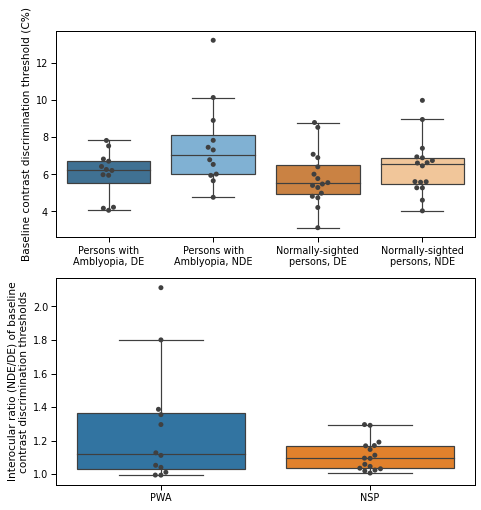

In [80]:
#with s.PdfPages(f"{plot_dir}/figure_06.pdf") as pdf:
sns.set_context(context="paper", font_scale=1.1)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))#, gridspec_kw={"width_ratios":[2, 1]})
g = sns.boxplot(data=baseline_df_withinsubject,
                x='Trace',
                y='BaselineThresh',#value',
                ax=ax[0],
                palette=pal4g, fliersize=0)
g = sns.swarmplot(data=baseline_df_withinsubject,
                  x='Trace',
                  y='BaselineThresh',
                  ax=ax[0], color=".25")
g.set_xlabel('')
g.set_ylabel('Baseline contrast discrimination threshold (C%)')
print(baseline_df_withinsubject.groupby(['Population'])['Subject'].nunique())


g2 = sns.boxplot(data=baseline_df_withinsubject_diffs,
                 x='Population',
                 #y='BaselineDiff',
                 y='BaselineRatio',
                 ax=ax[1],
                 fliersize=0, palette=colors2)
g2 = sns.swarmplot(data=baseline_df_withinsubject_diffs,
                   x='Population',
                   #y='BaselineDiff',
                   y='BaselineRatio',
                   ax=ax[1],
                   color=".25")
#g2.legend().remove()
g2.set_xlabel('')
#g2.set_ylabel('Interocular difference (NDE-DE) in baseline\ncontrast discrimination thresholds (C%)')
g2.set_ylabel('Interocular ratio (NDE/DE) of baseline\ncontrast discrimination thresholds')
plt.subplots_adjust(left=.12, right=.95, top=.95, bottom=.05, hspace=.2)
print(baseline_df_withinsubject_diffs.groupby(['Population'])['Subject'].nunique())

fig.savefig(f"{plot_dir}/figure_06.eps")
plt.show()
plt.close('all')

In [81]:
baseline_df_withinsubject.groupby(['Population','Eye']).describe()

BaselineThresh                                              \
                        count      mean       std    min      25%     50%   
Population Eye                                                              
NSP        De            16.0  5.818812  1.476632  3.124  4.94325  5.5150   
           Nde           16.0  6.412688  1.515690  4.033  5.50100  6.5345   
PWA        De            12.0  6.015333  1.257427  4.063  5.51850  6.2360   
           Nde           12.0  7.548417  2.312438  4.764  5.99650  7.0515   

                                BaselineDiff            ...                  \
                    75%     max        count      mean  ...      75%    max   
Population Eye                                          ...                   
NSP        De   6.52875   8.794         16.0  0.593875  ...  0.92500  1.473   
           Nde  6.90475   9.987         16.0  0.593875  ...  0.92500  1.473   
PWA        De   6.73825   7.827         12.0  1.533083  ...  2.35625  6.964   
           Nde  8.10225  13.226         12.0  1.533083  ...  2.35625  6.964   

               BaselineRatio                                          \
                       count      mean       std       min       25%   
Population Eye                                                         
NSP        De           16.0  1.111493  0.092259  1.006232  1.034256   
           Nde          16.0  1.111493  0.092259  1.006232  1.034256   
PWA        De           12.0  1.273315  0.353819  0.993814  1.032803   
           Nde          12.0  1.273315  0.353819  0.993814  1.032803   

                                              
                     50%       75%       max  
Population Eye                                
NSP        De   1.094398  1.168994  1.295486  
           Nde  1.094398  1.168994  1.295486  
PWA        De   1.119341  1.362562  2.112105  
           Nde  1.119341  1.362562  2.112105  

[4 rows x 24 columns]

In [82]:
baseline_df_withinsubject.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,BaselineDiff,BaselineRatio
128,SS,Iso,nDicho,NSP,ai,De,"Normally-sighted\npersons, DE",6.900,0.043,1.006232
129,SS,Iso,nDicho,NSP,ai,Nde,"Normally-sighted\npersons, NDE",6.943,0.043,1.006232
132,SS,Iso,nDicho,NSP,cr,De,"Normally-sighted\npersons, DE",3.124,0.909,1.290973
133,SS,Iso,nDicho,NSP,cr,Nde,"Normally-sighted\npersons, NDE",4.033,0.909,1.290973
134,SS,Iso,nDicho,NSP,ct,De,"Normally-sighted\npersons, DE",8.794,0.163,1.018535


In [83]:
def test_eye_diffs(g, col):
    #print(g.head())
    ndes = g[g.Eye=='Nde'][['Subject',col]].sort_values(by=['Subject'])
    des = g[g.Eye=='De'][['Subject',col]].sort_values(by=['Subject'])
    diffs = g.groupby(['Subject']).apply(utils.get_interocular_diff, col).drop_duplicates(subset=['Subject','ValueRatio'])
    assert(ndes.Subject.array.equals(des.Subject.array))
    #print(diffs[['Subject','ValueRatio']])
    #res = st.ttest_rel(ndes[col], des[col])
    res = st.ttest_1samp(diffs['ValueRatio'], popmean=1)
    print(f"N=({len(ndes)}, {len(des)}, diffs={len(diffs)})\n1sample (NDE/DE): t={res.statistic:.2f}, p={res.pvalue:.2f}")
    return res, diffs

for gv, g in baseline_df_withinsubject.groupby(['Task','Orientation','Presentation']):
    print(gv)
    for gv2, g2 in g.groupby(['Population']):
        print(gv2)
        res, diffs = test_eye_diffs(g2, "BaselineThresh")

('SS', 'Iso', 'nDicho')
NSP
N=(16, 16, diffs=16)
1sample (NDE/DE): t=4.83, p=0.00
PWA
N=(12, 12, diffs=12)
1sample (NDE/DE): t=2.68, p=0.02


### GABA vs baseline contrast threshold

In [84]:
baseline_gaba_plot_df = df_to_model.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [85]:
simple_bg_df = baseline_gaba_plot_df.groupby(['Task','Orientation','Presentation','Population','Subject','Eye','Trace'])[['GABA','BaselineThresh']].agg(np.mean).reset_index()

In [86]:
simple_bg_df = simple_bg_df.rename(columns={"BaselineThresh":"value"})
simple_bg_df['measure'] = "BaselineThresh"
simple_bg_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
0,SS,Cross,nDicho,NSP,ai,De,Control-De,0.223,6.900,BaselineThresh
1,SS,Cross,nDicho,NSP,ai,Nde,Control-Nde,0.223,6.943,BaselineThresh
2,SS,Cross,nDicho,NSP,cr,De,Control-De,0.201,3.124,BaselineThresh
3,SS,Cross,nDicho,NSP,cr,Nde,Control-Nde,0.201,4.033,BaselineThresh
4,SS,Cross,nDicho,NSP,ct,De,Control-De,0.208,8.794,BaselineThresh


In [87]:
len(simple_bg_df.Subject.unique())

28

In [88]:
simple_bg_df.Trace = simple_bg_df.Trace.astype('category')
simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
simple_bg_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [89]:
simple_bg_df.groupby(['Task','Orientation','Presentation','Population', 'Eye', 'measure'])['value'].describe()

count      mean  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
     Iso         nDicho       NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   
                 nMono        NSP        De  BaselineThresh   16.0  5.818812   
                                         Nde BaselineThresh   16.0  6.412688   
                              PWA        De  BaselineThresh   12.0  6.015333   
                                         Nde BaselineThresh   12.0  7.548417   

                                                                  std    min  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
     Iso         nDicho       NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   
                 nMono        NSP        De  BaselineThresh  1.476632  3.124   
                                         Nde BaselineThresh  1.515690  4.033   
                              PWA        De  BaselineThresh  1.257427  4.063   
                                         Nde BaselineThresh  2.312438  4.764   

                                                                 25%     50%  \
Task Orientation Presentation Population Eye measure                           
SS   Cross       nDicho       NSP        De  BaselineThresh  4.94325  5.5150   
                                         Nde BaselineThresh  5.50100  6.5345   
                              PWA        De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
                 nMono        NSP        De  BaselineThresh  4.94325  5.5150   
                                         Nde BaselineThresh  5.50100  6.5345   
                              PWA        De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
     Iso         nDicho       NSP        De  BaselineThresh  4.94325  5.5150   
                                         Nde BaselineThresh  5.50100  6.5345   
                              PWA        De  BaselineThresh  5.51850  6.2360   
                                         Nde BaselineThresh  5.99650  7.0515   
                 nMono        NSP        De  BaselineThresh

#### Drop subjects without GABA

In [90]:
simple_bg_df_nonan = simple_bg_df[~np.isnan(simple_bg_df.GABA)]

In [91]:
simple_bg_df_nonan_onecond = (simple_bg_df_nonan[(simple_bg_df_nonan['Presentation']=='nDicho') & (simple_bg_df_nonan['Orientation']=='Iso')])

In [92]:
simple_bg_df_nonan_onecond[simple_bg_df_nonan_onecond.Population=='PWA'].Subject.unique()

array(['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd'], dtype=object)

In [93]:
# check swapped eyes subs
simple_bg_df_nonan_onecond

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
112,SS,Iso,nDicho,NSP,ai,De,"Normally-sighted\npersons, DE",0.223,6.900,BaselineThresh
113,SS,Iso,nDicho,NSP,ai,Nde,"Normally-sighted\npersons, NDE",0.223,6.943,BaselineThresh
114,SS,Iso,nDicho,NSP,cr,De,"Normally-sighted\npersons, DE",0.201,3.124,BaselineThresh
115,SS,Iso,nDicho,NSP,cr,Nde,"Normally-sighted\npersons, NDE",0.201,4.033,BaselineThresh
116,SS,Iso,nDicho,NSP,ct,De,"Normally-sighted\npersons, DE",0.208,8.794,BaselineThresh
117,SS,Iso,nDicho,NSP,ct,Nde,"Normally-sighted\npersons, NDE",0.208,8.957,BaselineThresh
118,SS,Iso,nDicho,NSP,dl,De,"Normally-sighted\npersons, DE",0.220,5.772,BaselineThresh
119,SS,Iso,nDicho,NSP,dl,Nde,"Normally-sighted\npersons, NDE",0.220,6.745,BaselineThresh
120,SS,Iso,nDicho,NSP,ei,De,"Normally-sighted\npersons, DE",0.200,4.985,BaselineThresh
121,SS,Iso,nDicho,NSP,ei,Nde,"Normally-sighted\npersons, NDE",0.200,6.458,BaselineThresh


### Figure 7

In [94]:
bg_groups = simple_bg_df_nonan.groupby(['Task','Orientation','Presentation','measure'])
#with s.PdfPages(f"{plot_dir}/figure_07.pdf") as pdf:
i = 0 # only do the first group since they're all the same
for gv, gr in bg_groups:
    if i==0:
        g = s.gaba_vs_psychophys_plot(gv, gr, legend=False,
                    log=True, ylim=(2.5, 16), truncate=False,
                    col="Population", col_order=["PWA", "NSP"], hue="Trace",
                    sharex=False, sharey=False,
                    palette=pal4g,
                    n_boot=n_boot, legend_img=False,
                    markers=['o','^','o','^'],
                    aspect=1)
        #g.fig.suptitle(f"{gv}", fontsize=10, y=0.999)
        g.set_titles("")
        #g.fig.subplots_adjust(left=.08, wspace=.2, right=.99)
        g.fig.savefig(f"{plot_dir}/figure_07.pdf")
        plt.close('all')
        i = 1

('SS', 'Cross', 'nDicho', 'BaselineThresh')
nDicho

Percentiles for individual eye correlations:
Amb DE 
Observed value of -0.405 is greater than 0.149 of bootstrap distribution, corresponding to p=0.30.
Amb NDE 
Observed value of -0.214 is greater than 0.293 of bootstrap distribution, corresponding to p=0.59.
Con DE 
Observed value of 0.249 is greater than 0.806 of bootstrap distribution, corresponding to p=0.39.
Con NDE 
Observed value of 0.218 is greater than 0.773 of bootstrap distribution, corresponding to p=0.45.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of 0.190 is greater than 0.627 of bootstrap distribution, corresponding to p=0.75.
Con NDE vs DE 
Observed value of -0.031 is greater than 0.468 of bootstrap distribution, corresponding to p=0.94.
Pop Amb vs Con 
Observed value of 0.221 is greater than 0.631 of bootstrap distribution, corresponding to p=0.74.
[0.298 0.586 0.388 0.454], [0.746 0.935 0.739]



## Plot and model the suppression data (RelMaskContrast vs ThreshElev)

In [95]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nMono,Iso,De,NSP,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2
1,ai,SS,nMono,Iso,De,NSP,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4
2,ai,SS,nMono,Iso,De,NSP,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6
14,cr,SS,nMono,Iso,De,NSP,10.0,0.906,0.006,3.201,Control-De,3.124,3.944,4
15,cr,SS,nMono,Iso,De,NSP,30.0,2.218,0.005,9.604,Control-De,3.124,11.345,6


In [96]:
np.unique(df_to_model.MaskContrast)

array([ 5., 10., 17., 18., 30., 32., 39., 45., 50., 56., 60., 62., 74.,
       79., 99.])

In [97]:
# #bins = [0, 6, 11, 19, 33, 51, 63, 80, 100] # 17/18, 30/32, 39/45/50, 56/60/62, 74/79, and 99%
# bins = [0, 6, 11, 19, 33, 63, 80, 100] # 17/18, 30/32, 39/45/50/56/60/62, 74/79, and 99%
# #bins = [0, 6, 11, 19, 33, 63, 100]# 17/18, 30/32, 39/45/50/56/60/62, 74/79/99%
# df_to_model['Bin2'] = pd.cut(df_to_model['MaskContrast'], bins=bins, labels=[x+1 for x in range(len(bins)-1)])

In [98]:
np.unique(df_to_model.RelMaskContrast)

array([ 0.561,  0.67 ,  0.683,  0.741,  0.745,  0.765,  0.778,  0.805,
        0.831,  0.841,  0.866,  0.892,  0.913,  0.986,  1.001,  1.085,
        1.116,  1.123,  1.137,  1.172,  1.187,  1.231,  1.276,  1.278,
        1.328,  1.341,  1.35 ,  1.361,  1.367,  1.412,  1.44 ,  1.449,
        1.451,  1.465,  1.473,  1.483,  1.491,  1.508,  1.513,  1.53 ,
        1.548,  1.557,  1.561,  1.61 ,  1.663,  1.664,  1.672,  1.681,
        1.682,  1.732,  1.769,  1.783,  1.785,  1.793,  1.801,  1.825,
        1.85 ,  1.89 ,  1.896,  1.897,  2.006,  2.021,  2.076,  2.111,
        2.298,  2.39 ,  2.396,  2.413,  2.419,  2.46 ,  2.461,  2.479,
        2.637,  2.652,  2.669,  2.683,  2.715,  2.754,  2.802,  2.811,
        2.827,  2.858,  2.874,  2.899,  2.958,  3.004,  3.118,  3.201,
        3.21 ,  3.286,  3.349,  3.402,  3.411,  3.515,  3.833,  4.051,
        4.085,  4.237,  4.249,  4.29 ,  4.321,  4.348,  4.353,  4.374,
        4.431,  4.538,  4.645,  4.688,  4.715,  4.744,  4.77 ,  4.827,
      

In [99]:
sns.relplot(data=df_to_model, x="MaskContrast", y="ThreshElev", hue="Trace",
                        row="Orientation",
                        #col="Population", col_order=["PWA", "NSP"],
                        col="Presentation", col_order=["nMono", "nDicho"],
                        palette=pal4, style="Eye", markers=['o','d'],
                        height=4.5, aspect=1.3)\
    .map(plt.axhline, y=1, linestyle='dotted', color='black')\
    .set(ylabel="Threshold Elevation")\
    .set(xlabel='Surround Contrast (C%)')
plt.close('all')

In [100]:
sns.relplot(data=df_to_model, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        row="Orientation",
                        #col="Population", col_order=["PWA", "NSP"],
                        col="Presentation", col_order=["nMono", "nDicho"],
                        palette=pal4, style="Eye", markers=['o','d'],
                        height=4.5, aspect=1.3)\
.map(plt.axhline, y=1, linestyle='dotted', color='black')\
.map(plt.axvline, x=2, linestyle='dotted', color='grey')\
.map(plt.axvline, x=5, linestyle='dotted', color='grey')\
.map(plt.axvline, x=10, linestyle='dotted', color='grey')\
.set(ylabel="Threshold Elevation")\
.set(xlabel='Relative surround contrast\n (multiples of baseline)')
plt.close('all')

## Pick critical value and observations closest to that
#### Everything after this must be repeated for different critical values to show robustness

In [101]:
def closest_obs(df, col, to):
    co = (df.iloc[np.argmin(np.abs(df[col] - to))])
    #print(co, co.name, co.index, sep='\n')
    return co

def annotate(data, field="hue", pos=(.05, .7), **kws):
    #print(field, data[['Eye',field]], kws)
    ax=plt.gca()
    for (i, (gv, g)) in enumerate(data.groupby(field)):
        print(i, gv)
        pos_this=(pos[0], pos[1]+(.05*i))
        annotation = f"{gv} n={len(g)}"
        ax.text(*pos_this, annotation, transform=ax.transAxes)
        


**Analysis at RelMaskContrast=5**

0 NSP
1 PWA
0 NSP
1 PWA
0 NSP
1 PWA
0 NSP
1 PWA


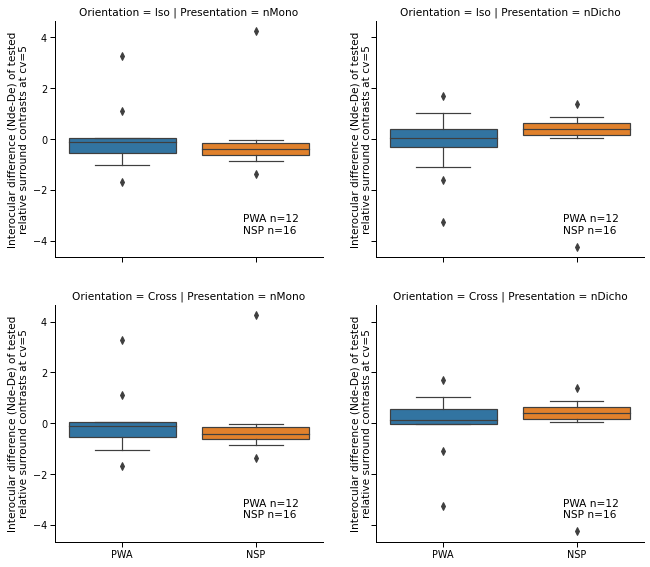

0 Amblyope-De
1 Amblyope-Nde
2 Control-De
3 Control-Nde
0 Amblyope-De
1 Amblyope-Nde
2 Control-De
3 Control-Nde
0 Amblyope-De
1 Amblyope-Nde
2 Control-De
3 Control-Nde
0 Amblyope-De
1 Amblyope-Nde
2 Control-De
3 Control-Nde


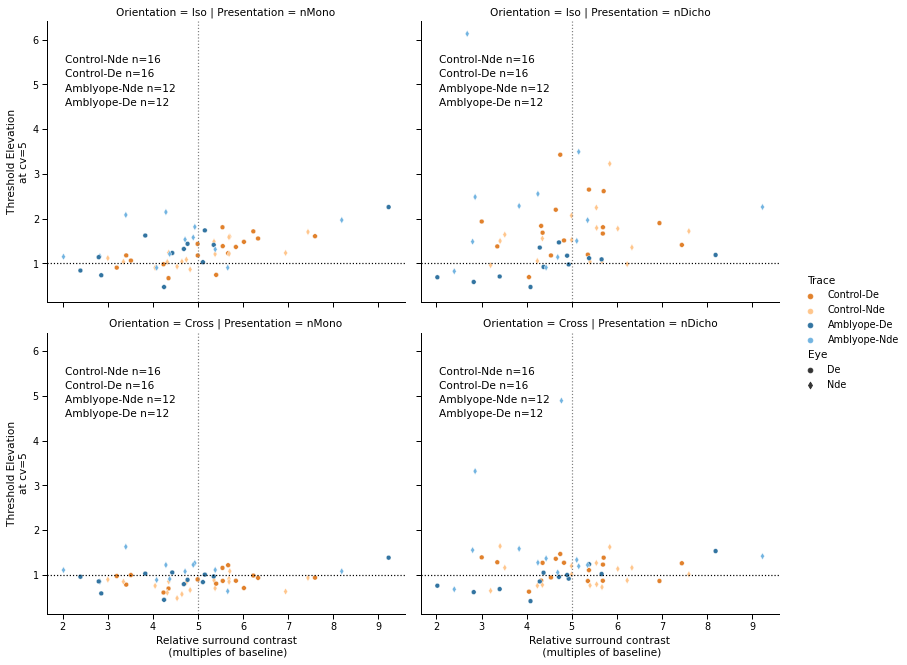

In [102]:
cv = 5
print(f"**Analysis at RelMaskContrast={cv}**\n")
final_obs = df_to_model.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)
sub_groups = final_obs.groupby(['Task','Orientation','Presentation','Population','Subject'], as_index=False)
xdiffs = sub_groups.apply(utils.get_interocular_diff, "RelMaskContrast").dropna().drop_duplicates(['Task','Orientation','Presentation','Subject','ValueDiff'])

#print(xdiffs)
#     sns.catplot(kind='bar', data=xmeans, x='Trace', y='RelMaskContrast', order=traces4, row="Orientation", col="Presentation", palette=pal4)\
#         .set(ylabel='Mean of relative surround contrasts tested')
g1 = sns.catplot(kind='box', data=xdiffs, x='Population', y='ValueDiff', order=["PWA", "NSP"],
            row="Orientation", row_order=["Iso", "Cross"],
            col="Presentation", col_order=["nMono", "nDicho"],
            height=4, aspect=1.1,
            palette=colors2)\
    .map_dataframe(annotate, field='Population', pos=(.7, .1))\
    .set(ylabel=f"Interocular difference (Nde-De) of tested\nrelative surround contrasts at cv={cv}")
g1.fig.subplots_adjust(wspace=.2, hspace=.2)
plt.show()
sns.relplot(data=final_obs, x="RelMaskContrast", y="ThreshElev", hue="Trace",
            row="Orientation", row_order=["Iso", "Cross"],
            col="Presentation", col_order=["nMono", "nDicho"],
            palette=pal4, style="Eye", markers=['o','d'],
            height=4.5, aspect=1.2)\
.map_dataframe(annotate)\
.map(plt.axhline, y=1, linestyle='dotted', color='black')\
.map(plt.axvline, x=cv, linestyle='dotted', color='grey')\
.set(ylabel=f"Threshold Elevation\nat cv={cv}")\
.set(xlabel='Relative surround contrast\n (multiples of baseline)')
plt.show()
plt.close('all')

In [103]:
final_obs.groupby(['Task','Orientation','Presentation','Population','Eye'])[['RelMaskContrast','ThreshElev']].describe(percentiles=[.5])

RelMaskContrast            \
                                                       count      mean   
Task Orientation Presentation Population Eye                             
SS   Cross       nDicho       NSP        De             16.0  5.001938   
                                         Nde            16.0  5.180063   
                              PWA        De             12.0  4.564167   
                                         Nde            12.0  4.572083   
                 nMono        NSP        De             16.0  5.180063   
                                         Nde            16.0  5.001938   
                              PWA        De             12.0  4.572083   
                                         Nde            12.0  4.564167   
     Iso         nDicho       NSP        De             16.0  5.001938   
                                         Nde            16.0  5.180063   
                              PWA        De             12.0  4.564167   
                                         Nde            12.0  4.398167   
                 nMono        NSP        De             16.0  5.180063   
                                         Nde            16.0  5.001938   
                              PWA        De             12.0  4.572083   
                                         Nde            12.0  4.564167   

                                                                              \
                                                   std    min     50%    max   
Task Orientation Presentation Population Eye                                   
SS   Cross       nDicho       NSP        De   1.164983  3.004  4.7855  7.438   
                                         Nde  1.194950  3.201  5.4740  7.594   
                              PWA        De   1.550175  2.021  4.5445  8.186   
                                         Nde  1.768702  2.396  4.5595  9.225   
                 nMono        NSP        De   1.194950  3.201  5.4740  7.594   
                                         Nde  1.164983  3.004  4.7855  7.438   
                              PWA        De   1.768702  2.396  4.5595  9.225   
                                         Nde  1.550175  2.021  4.5445  8.186   
     Iso         nDicho       NSP        De   1.164983  3.004  4.7855  7.438   
                                         Nde  1.194950  3.201  5.4740  7.594   
                              PWA        De   1.550175  2.021  4.5445  8.186   
                                         Nde  1.848288  2.396  4.3400  9.225   
                 nMono        NSP        De   1.194950  3.201  5.4740  7.594   
                                         Nde  1.164983  3.004  4.7855  7.438   
                              PWA        De   1.768702  2.396  4.5595  9.225   
                                         Nde  1.550175  2.021  4.5445  8.186   

                                             ThreshElev                      \
                                                  count      mean       std   
Task Orientation Presentation Population Eye                                  
SS   Cross       nDicho       NSP        De        16.0  1.130500  0.252378   
                                         Nde       16.0  1.035813  0.303820   
                              PWA        De        12.0  0.921167  0.293242   
                                         Nde       12.0  1.742000  1.178050   
                 nMono        NSP        De        16.0  0.897125  0.159301   
                                         Nde       16.0  0.782062  0.159986   
                              PWA        De        12.0  0.902167  0.237104   
                                         Nde       12.0  1.084417  0.251255   
     Iso         nDicho       NSP        De        16.0  1.818750  0.664917   
                                         Nde       16.0  1.593687  0.585806   
                              PWA        De        12.0  0.979167  0.311035   
           

### Table 3: Psychophysical results (t-tests of relative threshold in NDE vs DE - as of 6/25/21 with the elimination of unpaired eyes, made this a paired t-test, then decided to go with 1samp of ratio)

In [104]:
for gv, g in final_obs.groupby(['Task','Orientation','Presentation']):
    print(gv)
    for gv2, g2 in g.groupby(['Population']):
        print(gv2)
        res, diffs = test_eye_diffs(g2, "ThreshElev")
        if gv2 =='NSP':
            c = diffs['ValueRatio']
        elif gv2 =='PWA':
            a = diffs['ValueRatio']
    print("Two-sided independent-samples t-tests of PWA vs NSP:\n", st.ttest_ind(a, c))
    del(a, c)

('SS', 'Cross', 'nDicho')
NSP
N=(16, 16, diffs=16)
1sample (NDE/DE): t=-1.45, p=0.17
PWA
N=(12, 12, diffs=12)
1sample (NDE/DE): t=2.38, p=0.04
Two-sided independent-samples t-tests of PWA vs NSP:
 Ttest_indResult(statistic=2.9111718821307915, pvalue=0.007293811319520908)
('SS', 'Cross', 'nMono')
NSP
N=(16, 16, diffs=16)
1sample (NDE/DE): t=-2.48, p=0.03
PWA
N=(12, 12, diffs=12)
1sample (NDE/DE): t=2.35, p=0.04
Two-sided independent-samples t-tests of PWA vs NSP:
 Ttest_indResult(statistic=3.4142769781201814, pvalue=0.0021074883154933166)
('SS', 'Iso', 'nDicho')
NSP
N=(16, 16, diffs=16)
1sample (NDE/DE): t=-1.40, p=0.18
PWA
N=(12, 12, diffs=12)
1sample (NDE/DE): t=3.42, p=0.01
Two-sided independent-samples t-tests of PWA vs NSP:
 Ttest_indResult(statistic=4.126379235236006, pvalue=0.0003360126706876677)
('SS', 'Iso', 'nMono')
NSP
N=(16, 16, diffs=16)
1sample (NDE/DE): t=0.11, p=0.92
PWA
N=(12, 12, diffs=12)
1sample (NDE/DE): t=2.21, p=0.05
Two-sided independent-samples t-tests of PWA vs

### Make Figure 3, the modeling example

In [105]:
onecond = df_to_model[(df_to_model.Orientation=="Iso") & (df_to_model.Presentation=="nDicho")]
ns_onecond = onecond.groupby(['Task','Orientation','Presentation','Population','Eye','Trace'])['Subject'].nunique().reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 8), dpi=300)

sns.scatterplot(data=onecond, ax=ax1, x="MaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend=False)
ax1.set(ylabel="Relative contrast\ndiscrimination threshold")
ax1.set(xlabel='Surround Contrast')
ax1.axhline(y=1, linestyle='dotted', color='grey')

sns.scatterplot(data=onecond, ax=ax2, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend=False)
ax2.set(ylabel="Relative contrast\ndiscrimination threshold")
ax2.set(xlabel='Relative surround contrast\n (multiples of baseline)')
ax2.axhline(y=1, linestyle='dotted', color='grey')
ax2.axvline(x=5, linestyle='dotted', color='black')
print()

final_obs_onecond = onecond.groupby(pp_gvars).apply(closest_obs, 'RelMaskContrast', cv).reset_index(drop=True)

sns.scatterplot(data=final_obs_onecond, ax=ax3, x="RelMaskContrast", y="ThreshElev", hue="Trace",
                        palette=pal4, legend="brief")
ax3.legend_.set_visible(False)
ax3.set(xlim=ax2.get_xlim())
ax3.set(ylabel="Relative contrast\ndiscrimination threshold")
ax3.set(xlabel='Relative surround contrast\n (multiples of baseline)')
ax3.axhline(y=1, linestyle='dotted', color='grey')
ax3.axvline(x=5, linestyle='dotted', color='black')
handles, labels = ax3.get_legend_handles_labels()
h_leg = []
l_leg = []
for (h, l) in zip(handles, labels):
    if l in traces4:
        i = traces4.index(l)
        n = ns_onecond[ns_onecond.Trace==l]['Subject'].iloc[0]
        print(h, l, i, n, traces_graph4[i])
        h_leg.append(h)
        l_leg.append(f"{traces_graph4[i]}\n(N={n})")

fig.legend(h_leg, l_leg, loc='center right')
#fig.legend(pal4g)
fig.subplots_adjust(hspace=.5, right=.7)
plt.savefig(f"{plot_dir}/figure_03.eps")
plt.close('all')


<matplotlib.collections.PathCollection object at 0x145c8a5e0> Control-De 2 16 Normally-sighted
persons, DE
<matplotlib.collections.PathCollection object at 0x145c8a9d0> Control-Nde 3 16 Normally-sighted
persons, NDE
<matplotlib.collections.PathCollection object at 0x145c8adc0> Amblyope-De 0 12 Persons with
Amblyopia, DE
<matplotlib.collections.PathCollection object at 0x145cdf1f0> Amblyope-Nde 1 12 Persons with
Amblyopia, NDE


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Subset to include only (GABA and psychophyics) subjects

In [106]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [107]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw'
 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [108]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='PWA'])
nsp_subjs = (gdf[gdf.Population=="NSP"])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are PWA.')
n_this_task = len(gdf)

Of the 22 subjects with GABA and SS data, 8 are PWA.


In [109]:
final_obs.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nDicho,Cross,De,NSP,30.0,0.874,0.009,4.321,Control-De,6.900,4.033,4
1,ai,SS,nDicho,Cross,Nde,NSP,30.0,0.778,0.009,4.348,Control-Nde,6.943,4.050,4
2,cr,SS,nDicho,Cross,De,NSP,30.0,1.262,0.009,7.438,Control-De,3.124,6.610,5
3,cr,SS,nDicho,Cross,Nde,NSP,10.0,0.646,0.005,3.201,Control-Nde,4.033,2.511,3
4,ct,SS,nDicho,Cross,De,NSP,30.0,1.284,0.008,3.349,Control-De,8.794,4.033,4


In [110]:
comb = final_obs.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb), len(comb_gabappsub))
comb_gabappsub.Subject.unique()

224 176


array(['ai', 'cr', 'ct', 'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk',
       'ms', 'nl', 'yl', 'bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd'],
      dtype=object)

In [111]:
comb.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,GABA
0,ai,SS,nDicho,Cross,De,NSP,30.0,0.874,0.009,4.321,Control-De,6.900,4.033,4,0.223
1,ai,SS,nDicho,Cross,Nde,NSP,30.0,0.778,0.009,4.348,Control-Nde,6.943,4.050,4,0.223
2,cr,SS,nDicho,Cross,De,NSP,30.0,1.262,0.009,7.438,Control-De,3.124,6.610,5,0.201
3,cr,SS,nDicho,Cross,Nde,NSP,10.0,0.646,0.005,3.201,Control-Nde,4.033,2.511,3,0.201
4,ct,SS,nDicho,Cross,De,NSP,30.0,1.284,0.008,3.349,Control-De,8.794,4.033,4,0.208


In [112]:
print(pp_gvars)

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace']


In [113]:
baz = pd.melt(comb, id_vars=(pp_gvars + ['RelMaskContrast','BaselineThresh','GABA']),
              value_vars=["ThreshElev"], var_name='measure')
baz.dropna(subset=['GABA'], inplace=True)
baz.Trace = baz.Trace.astype('category')
baz_temp = baz.Trace.copy()
baz.Trace.cat.reorder_categories(traces4, inplace=True)
assert(baz_temp.equals(baz.Trace))
baz.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [114]:
pal4g

{'Persons with\nAmblyopia, DE': '#3274a1',
 'Persons with\nAmblyopia, NDE': '#72b4e1',
 'Normally-sighted\npersons, DE': '#e1812c',
 'Normally-sighted\npersons, NDE': '#ffc68c'}

#### Figures 8 and 9 and produced here

In [115]:
%%time
fig_groups = baz.groupby(['Task', 'Orientation', 'measure'])
for fgv, fg in fig_groups:
    #print(fg)
    assert(fg['Orientation'].nunique()==1) # we're only looking at one surround orientation per figure
    o = fg['Orientation'].iloc[0] # first element can be used for all
    if o=="Cross":
        # figure 8
        outfile = f"{plot_dir}/figure_08.pdf"
        ylim = (0.2,4)
    elif o=="Iso":
        # figure 9
        outfile = f"{plot_dir}/figure_09.pdf"
        ylim = (0.2, 6)
    else:
        # problem
        raise Error
    g = s.gaba_vs_psychophys_plot(fgv, fg, 
                legend_img = False,
                legend = False,
                log = True,
                sharex=False, sharey=False,
                truncate=False,
                ylim = ylim,
                row="Presentation", row_order=["nDicho", "nMono"],
                col="Population", col_order=["PWA","NSP"],
                hue="Trace",
                palette=pal4g,
                annotate=True, boot_func=utils.compare_rs, 
                n_boot=n_boot,
                markers=['o','d','o','d'])#, legend=False)
    g.set_titles("") # top row is dichoptic
    print(g.fig.get_size_inches(), g.fig.get_dpi())
    g.fig.subplots_adjust(left=.1, right=.95, wspace=0.15)
    g.fig.set_dpi(300)
    g.fig.set_size_inches((7,7))
    g.fig.savefig(outfile, dpi='figure')
    plt.close('all')

('SS', 'Cross', 'ThreshElev')
nDicho

Percentiles for individual eye correlations:
Amb DE 
Observed value of 0.738 is greater than 0.976 of bootstrap distribution, corresponding to p=0.05.
Amb NDE 
Observed value of -0.357 is greater than 0.181 of bootstrap distribution, corresponding to p=0.36.
Con DE 
Observed value of 0.022 is greater than 0.531 of bootstrap distribution, corresponding to p=0.94.
Con NDE 
Observed value of 0.151 is greater than 0.699 of bootstrap distribution, corresponding to p=0.60.

Percentiles for permuted r_s differences:
Amb NDE vs DE 
Observed value of -1.095 is greater than 0.017 of bootstrap distribution, corresponding to p=0.03.
Con NDE vs DE 
Observed value of 0.129 is greater than 0.625 of bootstrap distribution, corresponding to p=0.75.
Pop Amb vs Con 
Observed value of -1.224 is greater than 0.032 of bootstrap distribution, corresponding to p=0.06.
[0.048 0.361 0.938 0.602], [0.035 0.75  0.064]

nMono

Percentiles for individual eye correlations:
Amb D

# Orientation-selective surround suppression analysis
 * 6/7/21 post MAS: made this analysis refer to final_obs, not baz, thus including psychophys subjects we don't have GABA for and necessatitating the removal of GABA - OSSS results

In [116]:
final_obs.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber
0,ai,SS,nDicho,Cross,De,NSP,30.0,0.874,0.009,4.321,Control-De,6.900,4.033,4
1,ai,SS,nDicho,Cross,Nde,NSP,30.0,0.778,0.009,4.348,Control-Nde,6.943,4.050,4
2,cr,SS,nDicho,Cross,De,NSP,30.0,1.262,0.009,7.438,Control-De,3.124,6.610,5
3,cr,SS,nDicho,Cross,Nde,NSP,10.0,0.646,0.005,3.201,Control-Nde,4.033,2.511,3
4,ct,SS,nDicho,Cross,De,NSP,30.0,1.284,0.008,3.349,Control-De,8.794,4.033,4


In [117]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace"]#, "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", "Trace"]#, "GABA"]
oss_df_gaba = baz.groupby(oss_gvars + ['GABA']).apply(utils.calculate_orientation_selective_suppression).reset_index().dropna()
oss_df = final_obs.groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression, col='ThreshElev').reset_index().dropna()
oss_df['measure'] = 'OSSSRatio'

Iso/Cross ratio: 2.1029748283752863
Iso/Cross ratio: 2.0012853470437015
Iso/Cross ratio: 1.1196513470681457
Iso/Cross ratio: 1.4860681114551082
Iso/Cross ratio: 1.0747663551401867
Iso/Cross ratio: 0.913572732805843
Iso/Cross ratio: 2.3335602450646697
Iso/Cross ratio: 1.7712933753943216
Iso/Cross ratio: 1.6145374449339205
Iso/Cross ratio: 1.5642605633802817
Iso/Cross ratio: 1.8860028860028861
Iso/Cross ratio: 1.9864532019704433
Iso/Cross ratio: 1.1885310290652003
Iso/Cross ratio: 1.5014778325123155
Iso/Cross ratio: 2.3907942238267146
Iso/Cross ratio: 2.266750948166877
Iso/Cross ratio: 1.3810623556581987
Iso/Cross ratio: 1.4430727023319616
Iso/Cross ratio: 1.3898061737257716
Iso/Cross ratio: 1.4139414802065406
Iso/Cross ratio: 1.2478813559322033
Iso/Cross ratio: 1.3524804177545693
Iso/Cross ratio: 2.195150115473441
Iso/Cross ratio: 1.6945812807881775
Iso/Cross ratio: 1.9138920780711826
Iso/Cross ratio: 1.1195899772209568
Iso/Cross ratio: 1.4675324675324677
Iso/Cross ratio: 1.168819982773

In [118]:
oss_df.head(n=5)

,Task,Presentation,Population,Subject,Eye,Trace,value,measure
0,SS,nDicho,NSP,ai,De,Control-De,2.102975,OSSSRatio
1,SS,nDicho,NSP,ai,Nde,Control-Nde,2.001285,OSSSRatio
2,SS,nDicho,NSP,cr,De,Control-De,1.119651,OSSSRatio
3,SS,nDicho,NSP,cr,Nde,Control-Nde,1.486068,OSSSRatio
4,SS,nDicho,NSP,ct,De,Control-De,1.074766,OSSSRatio


In [119]:
oss_df.groupby(['Task', 'Presentation', 'Population','Eye'])['value'].agg(['mean', 'sem'])

mean       sem
Task Presentation Population Eye                    
SS   nDicho       NSP        De   1.608720  0.115064
                             Nde  1.549659  0.087678
                  PWA        De   1.083988  0.072228
                             Nde  1.383720  0.177610
     nMono        NSP        De   1.427882  0.087824
                             Nde  1.562478  0.065940
                  PWA        De   1.381474  0.077995
                             Nde  1.362341  0.069941

## Table 4: OSSS results (two-tailed 1-samp  t-tests)

In [120]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)#, g, sep='\n')
    ttres = st.ttest_1samp(g['value'], popmean=1, nan_policy='omit')
    print(f"N = {len(g)}, mean Iso/Cross ratio: {g['value'].mean():.2f}, t={ttres.statistic:.2f}, p={ttres.pvalue}")
    #print(st.spearmanr(g['GABA'], g['value']))

('SS', 'nDicho', 'NSP', 'De')
N = 16, mean Iso/Cross ratio: 1.61, t=5.29, p=9.070926667930878e-05
('SS', 'nDicho', 'NSP', 'Nde')
N = 16, mean Iso/Cross ratio: 1.55, t=6.27, p=1.5037184430919884e-05
('SS', 'nDicho', 'PWA', 'De')
N = 12, mean Iso/Cross ratio: 1.08, t=1.16, p=0.2695101513990171
('SS', 'nDicho', 'PWA', 'Nde')
N = 12, mean Iso/Cross ratio: 1.38, t=2.16, p=0.053661004493975206
('SS', 'nMono', 'NSP', 'De')
N = 16, mean Iso/Cross ratio: 1.43, t=4.87, p=0.0002031346818837806
('SS', 'nMono', 'NSP', 'Nde')
N = 16, mean Iso/Cross ratio: 1.56, t=8.53, p=3.873447169226604e-07
('SS', 'nMono', 'PWA', 'De')
N = 12, mean Iso/Cross ratio: 1.38, t=4.89, p=0.0004784452869538442
('SS', 'nMono', 'PWA', 'Nde')
N = 12, mean Iso/Cross ratio: 1.36, t=5.18, p=0.0003034431311345164


In [121]:
for gv, g in oss_df_gaba.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)#, g, sep='\n')
    ttres = st.ttest_1samp(g['value'], popmean=1, nan_policy='omit')
    print(f"N = {len(g)}, mean Iso/Cross ratio: {g['value'].mean():.2f}, t={ttres.statistic:.2f}, p={ttres.pvalue}")
    print(st.spearmanr(g['GABA'], g['value']), "\n")

('SS', 'nDicho', 'NSP', 'De')
N = 14, mean Iso/Cross ratio: 1.66, t=5.36, p=0.0001303773444162569
SpearmanrResult(correlation=0.1584159374450008, pvalue=0.5885690796887757) 

('SS', 'nDicho', 'NSP', 'Nde')
N = 14, mean Iso/Cross ratio: 1.55, t=5.54, p=9.613432871389787e-05
SpearmanrResult(correlation=0.27942811188215416, pvalue=0.3332909251378404) 

('SS', 'nDicho', 'PWA', 'De')
N = 8, mean Iso/Cross ratio: 0.98, t=-0.42, p=0.6901085014416515
SpearmanrResult(correlation=-0.023809523809523815, pvalue=0.9553740118158807) 

('SS', 'nDicho', 'PWA', 'Nde')
N = 8, mean Iso/Cross ratio: 1.33, t=1.31, p=0.23107235832337025
SpearmanrResult(correlation=0.04761904761904763, pvalue=0.9108491685195836) 

('SS', 'nMono', 'NSP', 'De')
N = 14, mean Iso/Cross ratio: 1.40, t=4.07, p=0.0013172702858345092
SpearmanrResult(correlation=-0.046204648421458556, pvalue=0.8753664744236946) 

('SS', 'nMono', 'NSP', 'Nde')
N = 14, mean Iso/Cross ratio: 1.60, t=8.59, p=1.0214362377737668e-06
SpearmanrResult(correla

In [122]:
# # combine both eyes (omit 'Eye' from grouping vars)
# def oss_mean_combeyes(df, **kwargs):
#     if len(df.Eye.unique())==2:
#         v1 = df[df.Eye=='Nde']['value'].iloc[0]
#         v2 = df[df.Eye=='De']['value'].iloc[0]
#         oss_mean_combeyes = np.mean([v1, v2])
#     elif len(df.Eye.unique())==1:
#         oss_mean_combeyes = df.value.iat[0]
#     else:
#         oss_mean_combeyes = np.nan
#     #print(df)
#     print(f"OSS mean across eyes: {oss_mean_combeyes}")
#     return pd.Series(oss_mean_combeyes, ['value'])
# oss_df_combeyes = oss_df.groupby(oss_gvars_combeyes).apply(oss_mean_combeyes).reset_index().dropna()
# for gv, g in oss_df_combeyes.groupby(['Task', 'Presentation', 'Population']):
#     print(gv, len(np.unique(g['Subject'])), np.unique(g['Subject']))#, g, sep='\n')
#     print(np.mean(g['value']), np.std(g['value']))
#     print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))
#     print(st.spearmanr(g['GABA'], g['value']))

In [123]:
# for gv, g in oss_df_combeyes.groupby(['Task', 'Presentation']):
#     print(gv, len(np.unique(g['Subject'])), np.unique(g['Subject']))#, g, sep='\n')
#     pwa = g[g.Population=='PWA']
#     nsp = g[g.Population=='NSP']
#     print('NSP: ', st.ttest_1samp(nsp['value'], popmean=1, nan_policy='omit'), 'PWA: ', st.ttest_1samp(pwa['value'], popmean=1, nan_policy='omit'), sep='\n')
#     print('NSP vs PWA 2-samp: ', st.ttest_ind(nsp['value'], pwa['value']))
#     for gv2, g2 in g.groupby(['Population']):
#         print(st.spearmanr(g2['GABA'], g2['value']))